In [3]:
import pandas as pd
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy.fft import fft, ifft
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedGroupKFold
from scipy.signal import savgol_filter
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.filterwarnings("ignore")

In [32]:
error_file=pd.read_csv(r'E:\glass_git\ML-DL\Signal&Table\data\cromate\Error_Lot_list.csv')
error=error_file[~error_file['1'].isnull()]
error_file=error['0'].tolist()
file_list=glob.glob(r'E:\glass_git\ML-DL\Signal&Table\data\cromate\kemp*.csv')
for i,file in enumerate(file_list):
    globals()[f'df_{i}']=pd.read_csv(file)
    globals()[f'df_{i}']['date']=file.split('-')[-1][:-4].replace('.','')
    globals()[f'df_{i}']['class']=0
    date=file.split('-')[-1][:-4].replace('.','-')
    if date in error_file:
        error_lots=error[error['0']==date]['1'].values.tolist()
        for error_lot in error_lots:
            print(i)
            globals()[f'df_{i}'].loc[globals()[f'df_{i}']['Lot']==error_lot, 'class'] = 1
    over_69=globals()[f'df_{i}']['Lot'].value_counts().where(lambda x: x > 69).dropna().sort_values(ascending=False)
    if len(over_69)>0:
        print(f'over 69 values : {i}')
    
    # 문자열 처리: 오전/오후 → AM/PM
    globals()[f'df_{i}']['Time'] = globals()[f'df_{i}']['Time'].astype(str).str.replace("오전", "AM").str.replace("오후", "PM") 
    globals()[f'df_{i}']['datetime_str']=globals()[f'df_{i}']['date']+' '+globals()[f'df_{i}']['Time']
    globals()[f'df_{i}']['datetime'] = pd.to_datetime(globals()[f'df_{i}']['datetime_str'], format="%Y%m%d %p %I:%M:%S.%f", errors='coerce')
    globals()[f'df_{i}'].drop(['datetime_str','Time','date'],axis=1, inplace=True)


2
3
3
8
13
16
18
29
30


In [5]:
def remove_outliers_iqr(df, column, factor=1.5):
    """
    특정 컬럼에 대해 IQR 방식으로 이상치를 제거한 데이터프레임을 반환합니다.
    
    Parameters:
    - df: 입력 DataFrame
    - column: 이상치 제거할 컬럼 이름 (str)
    - factor: IQR 범위 계수 (기본값 1.5)
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # 이상치가 아닌 것만 필터링
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
df_feature_engineering=[]

for i in range(len(file_list)):
     globals()[f'df_{i}']['run_time']=globals()[f'df_{i}']['datetime']-globals()[f'df_{i}']['datetime'].shift(1)
     globals()[f'df_{i}']['run_time']=pd.to_timedelta(globals()[f'df_{i}']['run_time']).dt.total_seconds()
     globals()[f'df_{i}']['run_time']=globals()[f'df_{i}']['run_time'].cumsum()
     
     globals()[f'df_{i}']['year']=globals()[f'df_{i}']['datetime'].dt.year
     globals()[f'df_{i}']['month']=globals()[f'df_{i}']['datetime'].dt.month
     globals()[f'df_{i}']['day']=globals()[f'df_{i}']['datetime'].dt.day
     globals()[f'df_{i}']['time']=globals()[f'df_{i}']['datetime'].dt.time
     globals()[f'df_{i}']['hour']=globals()[f'df_{i}']['datetime'].dt.hour
     globals()[f'df_{i}']['minutes']=globals()[f'df_{i}']['datetime'].dt.minute
     globals()[f'df_{i}']['seconds']=globals()[f'df_{i}']['datetime'].dt.second
     
     globals()[f'df_{i}']=remove_outliers_iqr(globals()[f'df_{i}'], 'pH', factor=1.5)
     globals()[f'df_{i}']=remove_outliers_iqr(globals()[f'df_{i}'], 'Temp', factor=1.5)
     globals()[f'df_{i}']=remove_outliers_iqr(globals()[f'df_{i}'], 'Voltage', factor=1.5)

     # globals()[f'df_{i}']['pH_fft'] = fft(globals()[f'df_{i}']['pH'])
     # globals()[f'df_{i}']['Temp_fft'] = fft(globals()[f'df_{i}']['Temp'])
     # globals()[f'df_{i}']['Voltage_fft'] = fft(globals()[f'df_{i}']['Voltage'])
     
     # globals()[f'df_{i}']['fft_pH_real'] = globals()[f'df_{i}']['pH_fft'].apply(lambda x: x.real)
     # globals()[f'df_{i}']['fft_pH_imag'] = globals()[f'df_{i}']['pH_fft'].apply(lambda x: x.imag)
     # globals()[f'df_{i}']['fft_pH_magnitude'] = globals()[f'df_{i}']['pH_fft'].apply(lambda x: abs(x))
     # globals()[f'df_{i}']['fft_pH_phase'] = globals()[f'df_{i}']['pH_fft'].apply(lambda x: np.angle(x))

     # globals()[f'df_{i}']['fft_Temp_real'] = globals()[f'df_{i}']['Temp_fft'].apply(lambda x: x.real)
     # globals()[f'df_{i}']['fft_Temp_imag'] = globals()[f'df_{i}']['Temp_fft'].apply(lambda x: x.imag)
     # globals()[f'df_{i}']['fft_Temp_magnitude'] = globals()[f'df_{i}']['Temp_fft'].apply(lambda x: abs(x))
     # globals()[f'df_{i}']['fft_Temp_phase'] = globals()[f'df_{i}']['Temp_fft'].apply(lambda x: np.angle(x))

     # globals()[f'df_{i}']['fft_Voltage_real'] = globals()[f'df_{i}']['Voltage_fft'].apply(lambda x: x.real)
     # globals()[f'df_{i}']['fft_Voltage_imag'] = globals()[f'df_{i}']['Voltage_fft'].apply(lambda x: x.imag)
     # globals()[f'df_{i}']['fft_Voltage_magnitude'] = globals()[f'df_{i}']['Voltage_fft'].apply(lambda x: abs(x))
     # globals()[f'df_{i}']['fft_Voltage_phase'] = globals()[f'df_{i}']['Voltage_fft'].apply(lambda x: np.angle(x))

     # globals()[f'df_{i}']['timestamp']=globals()[f'df_{i}']['run_time'].dt.total_seconds()
     
     # globals()[f'df_{i}']['pH_lag_1'] = globals()[f'df_{i}']['pH'].shift(1)
     # globals()[f'df_{i}']['pH_lag_3'] = globals()[f'df_{i}']['pH'].shift(3)
     # globals()[f'df_{i}']['pH_lag_5'] = globals()[f'df_{i}']['pH'].shift(5)
     
     # globals()[f'df_{i}']['Temp_lag_1'] = globals()[f'df_{i}']['Temp'].shift(1)
     # globals()[f'df_{i}']['Temp_lag_3'] = globals()[f'df_{i}']['Temp'].shift(3)
     # globals()[f'df_{i}']['Temp_lag_5'] = globals()[f'df_{i}']['Temp'].shift(5)
     
     # globals()[f'df_{i}']['Voltage_lag_1'] = globals()[f'df_{i}']['Voltage'].shift(1)
     # globals()[f'df_{i}']['Voltage_lag_3'] = globals()[f'df_{i}']['Voltage'].shift(3)
     # globals()[f'df_{i}']['Voltage_lag_5'] = globals()[f'df_{i}']['Voltage'].shift(5)

     # globals()[f'df_{i}']['pH_diff1']=globals()[f'df_{i}']['pH']-globals()[f'df_{i}']['pH'].shift(1)
     # globals()[f'df_{i}']['pH_diff3']=globals()[f'df_{i}']['pH']-globals()[f'df_{i}']['pH'].shift(3)
     # globals()[f'df_{i}']['pH_diff5']=globals()[f'df_{i}']['pH']-globals()[f'df_{i}']['pH'].shift(5)

     # globals()[f'df_{i}']['Temp_diff1']=globals()[f'df_{i}']['Temp']-globals()[f'df_{i}']['Temp'].shift(1)
     # globals()[f'df_{i}']['Temp_diff3']=globals()[f'df_{i}']['Temp']-globals()[f'df_{i}']['Temp'].shift(3)
     # globals()[f'df_{i}']['Temp_diff5']=globals()[f'df_{i}']['Temp']-globals()[f'df_{i}']['Temp'].shift(5)

     # globals()[f'df_{i}']['Voltage_diff1']=globals()[f'df_{i}']['Voltage']-globals()[f'df_{i}']['Voltage'].shift(1)
     # globals()[f'df_{i}']['Voltage_diff3']=globals()[f'df_{i}']['Voltage']-globals()[f'df_{i}']['Voltage'].shift(3)
     # globals()[f'df_{i}']['Voltage_diff5']=globals()[f'df_{i}']['Voltage']-globals()[f'df_{i}']['Voltage'].shift(5)

     #전처리 smoothing, 테스트 결과 smooth은 안하는게 좋음  
     # globals()[f'df_{i}']['pH_smooth'] = savgol_filter(globals()[f'df_{i}']['pH'], window_length=4, polyorder=2)
     # globals()[f'df_{i}']['Temp_smooth'] = savgol_filter(globals()[f'df_{i}']['Temp'], window_length=4, polyorder=2)
     # globals()[f'df_{i}']['Voltage_smooth'] = savgol_filter(globals()[f'df_{i}']['Voltage'], window_length=4, polyorder=2)
     if i==0:
          globals()[f'df_{i}'].fillna(0,inplace=True)
          df_name=globals()[f'df_{i}']['datetime'][0].strftime('%y%m%d')
          globals()[f'df_{i}'].to_csv(f'E:/glass_git/ML-DL/Signal&Table/data/cromate/preped/df_{df_name}.csv',index=False)
          df_feature_engineering.append(globals()[f'df_{i}'])
          Lot_index=int(globals()[f'df_{i}']['Lot'].max())
          # print(f'min: {globals()[f'df_{i}']['Lot'].min()}, max: {globals()[f'df_{i}']['Lot'].max()}')
     else:
          # print(globals()[f'df_{i}']['Lot'].unique())
          globals()[f'df_{i}']['Lot']=globals()[f'df_{i}']['Lot']+Lot_index
          # print(globals()[f'df_{i}']['Lot'].unique())
          globals()[f'df_{i}'].fillna(0,inplace=True)
          df_name=globals()[f'df_{i}']['datetime'][0].strftime('%y%m%d')
          globals()[f'df_{i}'].to_csv(f'E:/glass_git/ML-DL/Signal&Table/data/cromate/preped/df_{df_name}.csv',index=False)
          df_feature_engineering.append(globals()[f'df_{i}'])
          Lot_index=int(globals()[f'df_{i}']['Lot'].max())
          # print(f'min: {globals()[f'df_{i}']['Lot'].min()}, max: {globals()[f'df_{i}']['Lot'].max()}')
          


In [34]:
merged_featured=pd.concat(df_feature_engineering,axis=0,ignore_index=True)
merged_featured.to_csv(f'E:/glass_git/ML-DL/Signal&Table/data/cromate/preped/df_merged.csv',index=False)

In [35]:
merged_featured

,Index,Lot,pH,Temp,Voltage,class,datetime,run_time,year,month,day,time,hour,minutes,seconds
0,1,1,2.15,43.15,19.74,0,2021-09-06 16:29:54.000,0.0,2021,9,6,16:29:54,16,29,54
1,2,1,2.08,40.13,18.01,0,2021-09-06 16:29:59.000,5.0,2021,9,6,16:29:59,16,29,59
2,3,1,2.18,43.46,18.73,0,2021-09-06 16:30:04.000,10.0,2021,9,6,16:30:04,16,30,4
3,4,1,1.99,41.72,16.75,0,2021-09-06 16:30:09.000,15.0,2021,9,6,16:30:09,16,30,9
4,5,1,1.85,43.65,18.02,0,2021-09-06 16:30:14.000,20.0,2021,9,6,16:30:14,16,30,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49261,1514,726,2.05,42.84,15.38,0,2021-10-27 18:36:03.300,8028.3,2021,10,27,18:36:03.300000,18,36,3
49262,1515,726,1.91,42.64,19.08,0,2021-10-27 18:36:08.300,8033.3,2021,10,27,18:36:08.300000,18,36,8
49263,1516,726,2.11,44.09,18.14,0,2021-10-27 18:36:13.300,8038.3,2021,10,27,18:36:13.300000,18,36,13
49264,1517,726,1.92,43.95,17.96,0,2021-10-27 18:36:18.300,8043.3,2021,10,27,18:36:18.300000,18,36,18


In [19]:
new_index=np.arange(0,7590,1)
df_interp = df_0.reindex(new_index)
df_interp.index.name = 'time'

# spline 보간 (3차 스플라인)
df_interp = df_interp[['pH','Temp','Voltage']].interpolate(method='spline', order=3)
df_interp

,pH,Temp,Voltage
time,,,
0,2.150000,4.315000e+01,1.974000e+01
1,2.041416,4.229750e+01,1.938469e+01
2,2.040656,4.188353e+01,1.915579e+01
3,2.039897,4.159190e+01,1.893611e+01
4,2.039139,4.140826e+01,1.872726e+01
...,...,...,...
7585,-12.532394,-1.019798e+07,-4.547296e+08
7586,-12.541698,-1.020870e+07,-4.552087e+08
7587,-12.551005,-1.021942e+07,-4.556882e+08


In [ ]:
df=pd.DataFrame()
iid=0
for i in range(len(file_list)):
    Lot_numer=globals()[f'df_{i}']['Lot'].unique()
    for num in Lot_numer:
        globals()[f'df_{i}'].loc[globals()[f'df_{i}']['Lot']==num, 'Index'] = iid
        iid+=1
    df=pd.concat([df,globals()[f'df_{i}']], ignore_index=True)

In [10]:
df.columns

Index(['Index', 'Lot', 'pH', 'Temp', 'Voltage', 'class', 'datetime',
       'run_time', 'year', 'month', 'day', 'time', 'hour', 'minutes',
       'seconds', 'pH_fft', 'Temp_fft', 'Voltage_fft', 'fft_pH_real',
       'fft_pH_imag', 'fft_pH_magnitude', 'fft_pH_phase', 'fft_Temp_real',
       'fft_Temp_imag', 'fft_Temp_magnitude', 'fft_Temp_phase',
       'fft_Voltage_real', 'fft_Voltage_imag', 'fft_Voltage_magnitude',
       'fft_Voltage_phase'],
      dtype='object')

In [6]:
normal_index_list=df[df['class']==0]['Index'].unique()
defect_index_list=df[df['class']==1]['Index'].unique()
print(f'normal {len(normal_index_list)}, defect {len(defect_index_list)}')

normal 717, defect 9


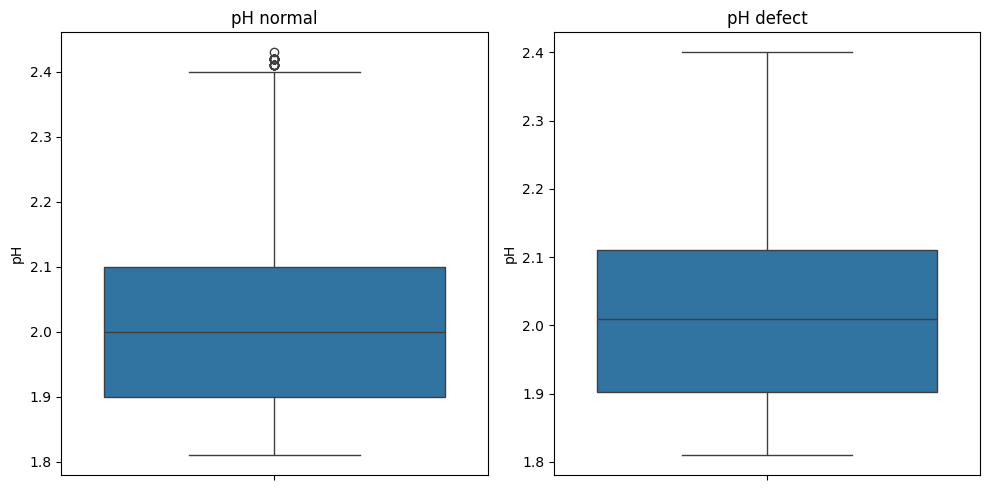

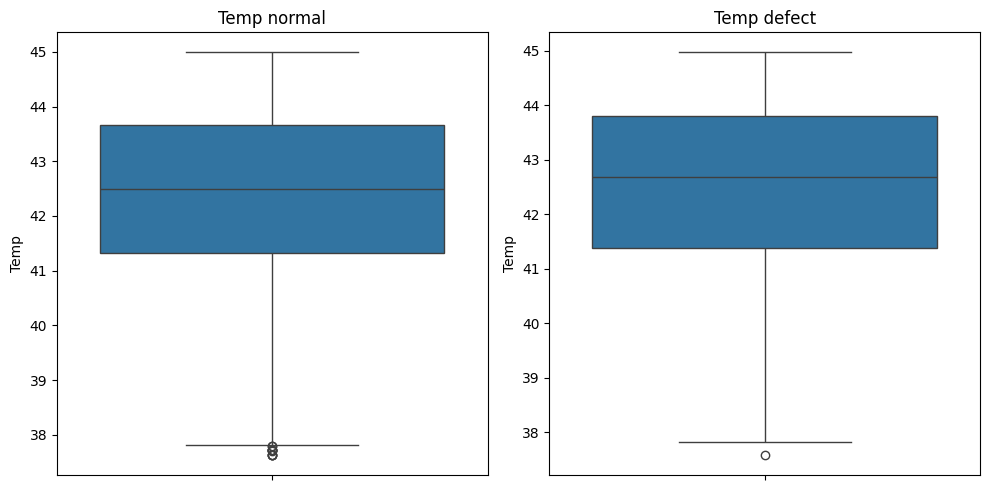

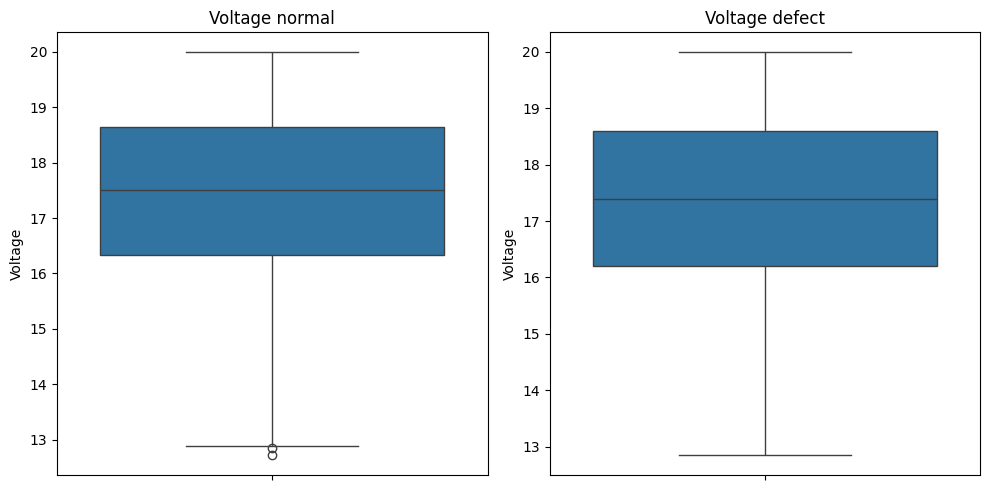

In [73]:
normal_df=df[df['Index'].isin(normal_index_list)]
defect_df=df[df['Index'].isin(defect_index_list)]

features=['pH', 'Temp', 'Voltage']

for f in features:
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
    # 첫 번째 박스플롯
    sns.boxplot(data=normal_df, y=f, ax=axes[0])
    axes[0].set_title(f"{f} normal")

    # 두 번째 박스플롯
    sns.boxplot(data=defect_df, y=f, ax=axes[1])
    axes[1].set_title(f"{f} defect")

    plt.tight_layout()
    plt.show()
    plt.close()


e:\glass_git\ML-DL\.conda\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
e:\glass_git\ML-DL\.conda\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


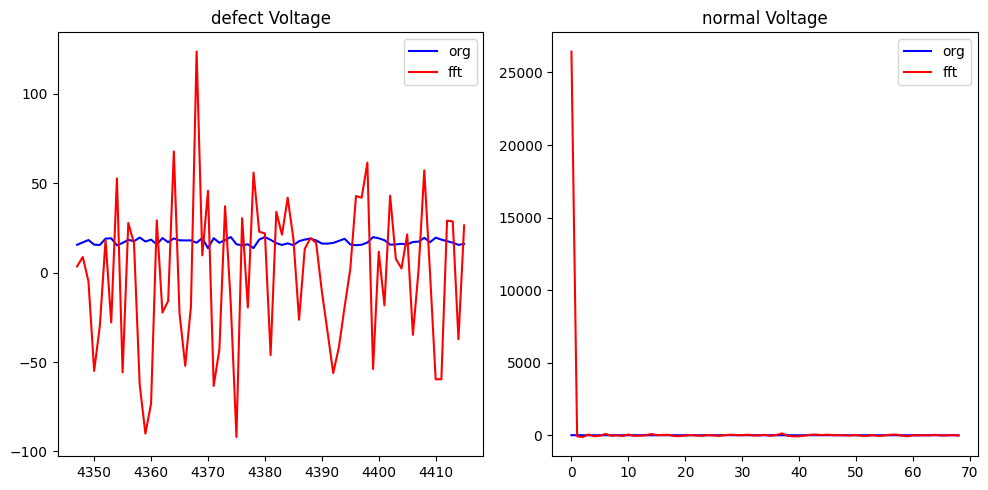

In [189]:
org_defect_line=df[df['Index']==63]['Voltage']
smooth_defect_line=df[df['Index']==63]['Voltage_fft']
org_normal_line=df[df['Index']==0]['Voltage']
smooth_normal_line=df[df['Index']==0]['Voltage_fft']

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].plot(org_defect_line,label='org',color='blue')
axes[0].plot(smooth_defect_line,label='fft',color='red')
axes[0].set_title('defect Voltage')
axes[0].legend(loc='upper right')

axes[1].plot(org_normal_line,label='org',color='blue')
axes[1].plot(smooth_normal_line,label='fft',color='red')
axes[1].set_title('normal Voltage')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()
plt.close()


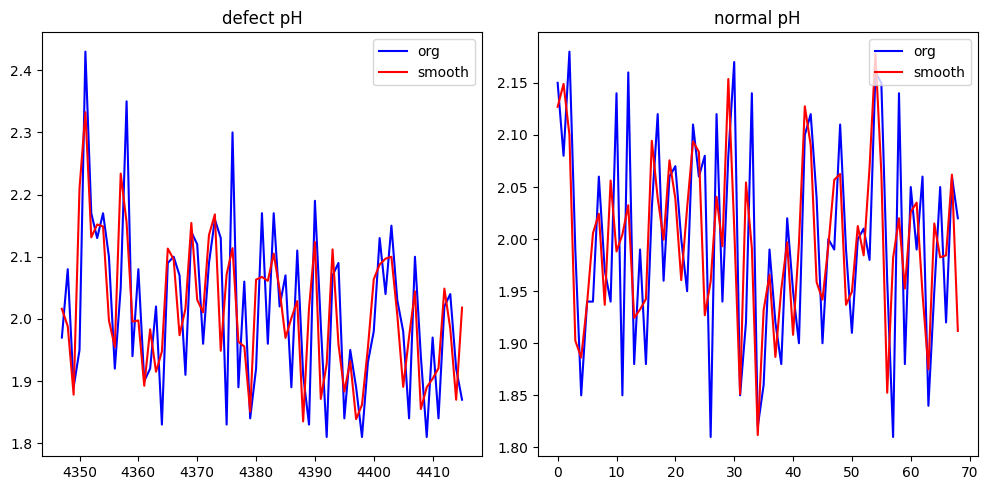

In [192]:
org_defect_line=df[df['Index']==63]['pH']
smooth_defect_line=df[df['Index']==63]['pH_smooth']
org_normal_line=df[df['Index']==0]['pH']
smooth_normal_line=df[df['Index']==0]['pH_smooth']

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].plot(org_defect_line,label='org',color='blue')
axes[0].plot(smooth_defect_line,label='smooth',color='red')
axes[0].set_title('defect pH')
axes[0].legend(loc='upper right')

axes[1].plot(org_normal_line,label='org',color='blue')
axes[1].plot(smooth_normal_line,label='smooth',color='red')
axes[1].set_title('normal pH')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()
plt.close()


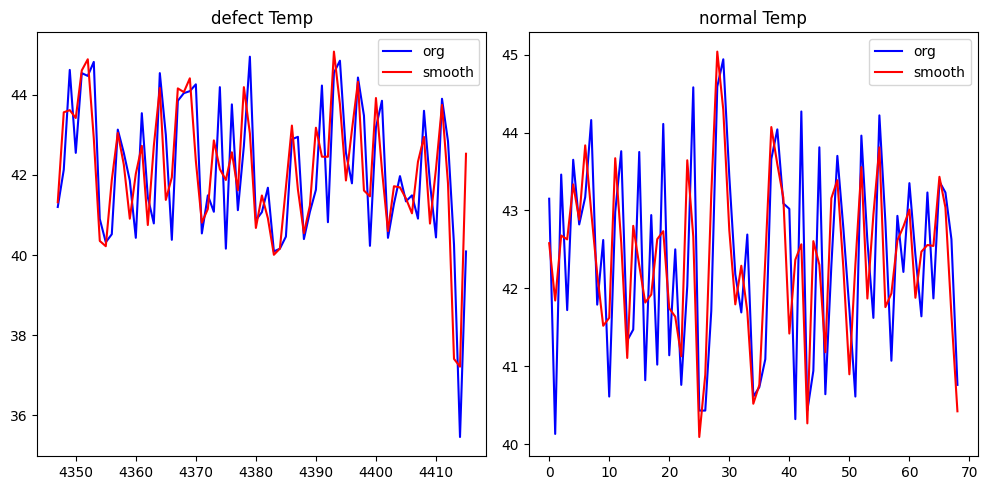

In [193]:
org_defect_line=df[df['Index']==63]['Temp']
smooth_defect_line=df[df['Index']==63]['Temp_smooth']
org_normal_line=df[df['Index']==0]['Temp']
smooth_normal_line=df[df['Index']==0]['Temp_smooth']

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].plot(org_defect_line,label='org',color='blue')
axes[0].plot(smooth_defect_line,label='smooth',color='red')
axes[0].set_title('defect Temp')
axes[0].legend(loc='upper right')

axes[1].plot(org_normal_line,label='org',color='blue')
axes[1].plot(smooth_normal_line,label='smooth',color='red')
axes[1].set_title('normal Temp')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()
plt.close()


### classification

- normal class 데이터가 717개 defect class가 9개로 class 불균형이 심함
- class 불균형이 너무 심하여 SMOTE 사용하기가 어려움. BORDERLINE이 분명하지 않음
- classification 모델로 구분이 확실한 data feature 생성 후 LSTM으로 미래 예측
- binary class 이므로 anomaly detection 모델 사용
- model validate는 Leave-One-Out 방식 사용

In [74]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators = 500,
                        learning_rate = 0.05,
                        use_label_encoder = False,
                        eval_metric = "error",
                        early_stopping_rounds = 5,
                        n_jobs = -1)

In [75]:
df.columns

Index(['Index', 'Lot', 'pH', 'Temp', 'Voltage', 'class', 'datetime',
       'run_time', 'year', 'month', 'day', 'time', 'hour', 'minutes',
       'seconds', 'pH_fft', 'Temp_fft', 'Voltage_fft', 'fft_pH_real',
       'fft_pH_imag', 'fft_pH_magnitude', 'fft_pH_phase', 'fft_Temp_real',
       'fft_Temp_imag', 'fft_Temp_magnitude', 'fft_Temp_phase',
       'fft_Voltage_real', 'fft_Voltage_imag', 'fft_Voltage_magnitude',
       'fft_Voltage_phase'],
      dtype='object')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49266 entries, 0 to 49265
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Index                  49266 non-null  int64         
 1   Lot                    49266 non-null  int64         
 2   pH                     49266 non-null  float64       
 3   Temp                   49266 non-null  float64       
 4   Voltage                49266 non-null  float64       
 5   class                  49266 non-null  int64         
 6   datetime               49266 non-null  datetime64[ns]
 7   run_time               49266 non-null  float64       
 8   year                   49266 non-null  int32         
 9   month                  49266 non-null  int32         
 10  day                    49266 non-null  int32         
 11  time                   49266 non-null  object        
 12  hour                   49266 non-null  int32         
 13  m

Fold: 0, defect_test_idx: {70}


e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


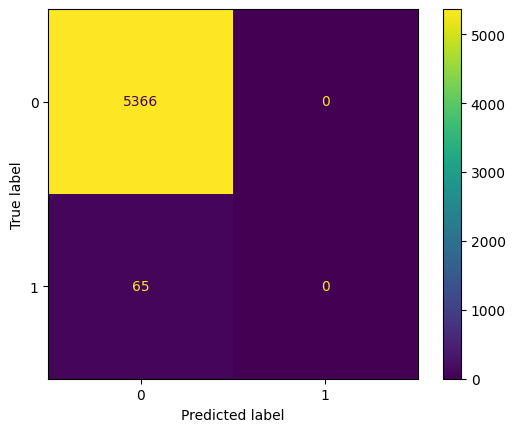

Fold: 1, defect_test_idx: {81}


e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


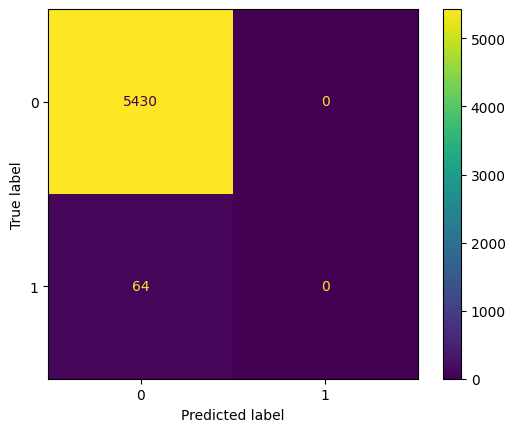

Fold: 2, defect_test_idx: {640}


e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


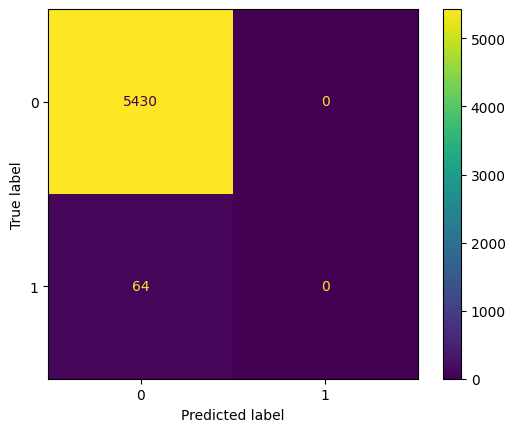

Fold: 3, defect_test_idx: {675}


e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


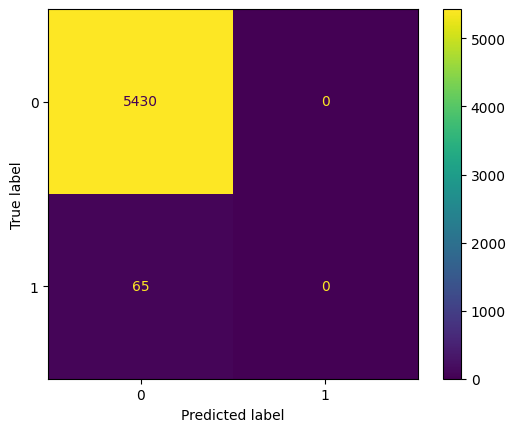

e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Fold: 4, defect_test_idx: {372}


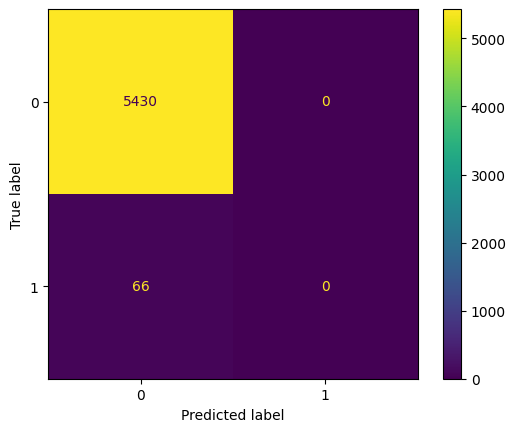

Fold: 5, defect_test_idx: {301}


e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


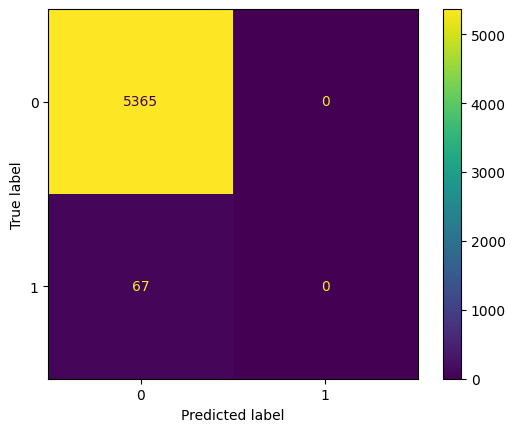

Fold: 6, defect_test_idx: {401}


e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


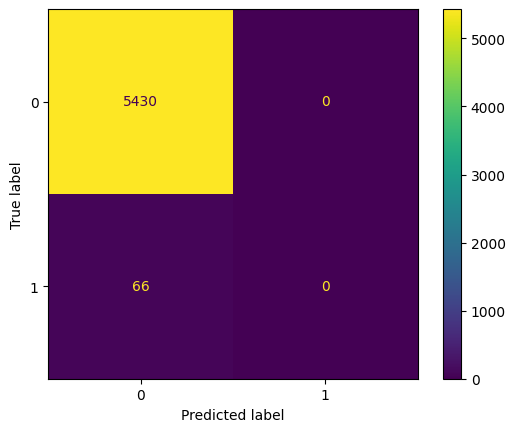

Fold: 7, defect_test_idx: {179}


e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


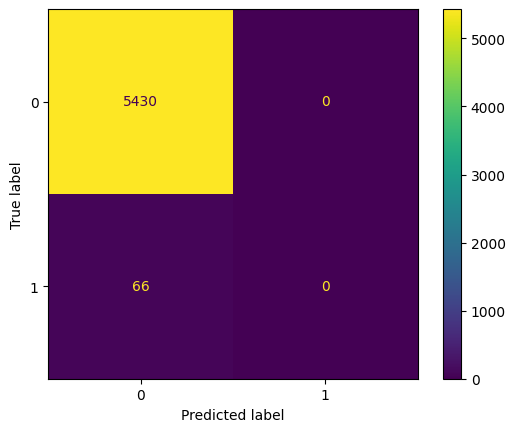

Fold: 8, defect_test_idx: {63}


e:\glass_git\ML-DL\.conda\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


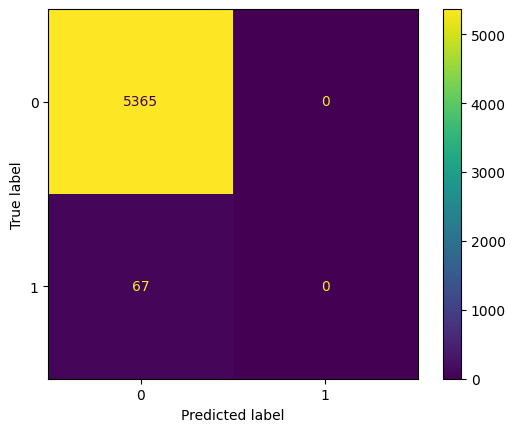

In [83]:
#year는 2021로 동일함으로 변수에서 제외, 스무딩 전 데이터
X_col=['pH','Temp','Voltage','run_time', 'month', 'day','hour', 'minutes',
       'seconds',  'fft_pH_real',
       'fft_pH_imag', 'fft_pH_magnitude', 'fft_pH_phase', 'fft_Temp_real',
       'fft_Temp_imag', 'fft_Temp_magnitude', 'fft_Temp_phase',
       'fft_Voltage_real', 'fft_Voltage_imag', 'fft_Voltage_magnitude',
       'fft_Voltage_phase']
y_col=['class']

# clf = make_pipeline(StandardScaler(), xgb_clf)
score=[]

X = df[X_col]
y = df[y_col]
groups = df['Index']

sgkf=StratifiedGroupKFold(n_splits=9, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    test_df=df[df['Index'].isin(groups[test_index].unique())]
    train_df=df[df['Index'].isin(groups[train_index].unique())]
    print(f'Fold: {i}, defect_test_idx: {set(defect_index_list)&set(groups[test_index].unique())}')

    train_x=train_df[X_col]
    scaler=StandardScaler()
    scaled_train_x=scaler.fit_transform(train_x)
    train_y=train_df[y_col]

    test_x=test_df[X_col]
    scaled_test_x=scaler.transform(test_x)
    test_y=test_df[y_col]

    #TRAIN
    xgb_clf.fit(scaled_train_x, train_y,                    
            eval_set = [(scaled_test_x,test_y)],
            verbose = False)
    
    # clf.fit(train_x, train_y)
    y_pred=xgb_clf.predict(scaled_test_x)
    score.append(xgb_clf.score(scaled_test_x,test_y))
    ConfusionMatrixDisplay.from_predictions(test_y, y_pred)
    plt.show()
    plt.close()

In [84]:
#accuracy는 높으나 이는 단순히 normal의 데이터가 많아서 높게 계산됨. defect는 전혀 맞추지 못함
score

[0.9880316700423495,
 0.9883509282854023,
 0.9883509282854023,
 0.9881710646041856,
 0.9879912663755459,
 0.9876656848306333,
 0.9879912663755459,
 0.9879912663755459,
 0.9876656848306333]

Fold: 0, defect_test_idx: {63}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


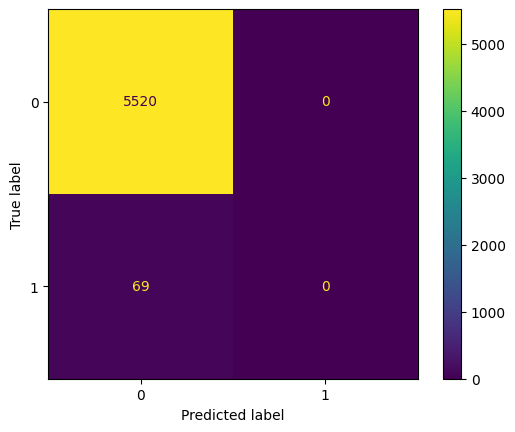

Fold: 1, defect_test_idx: {81}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


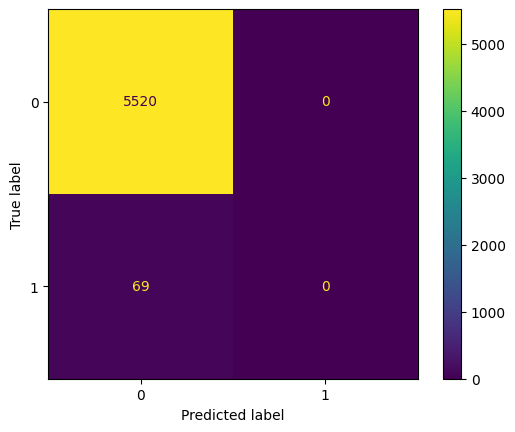

Fold: 2, defect_test_idx: {301}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


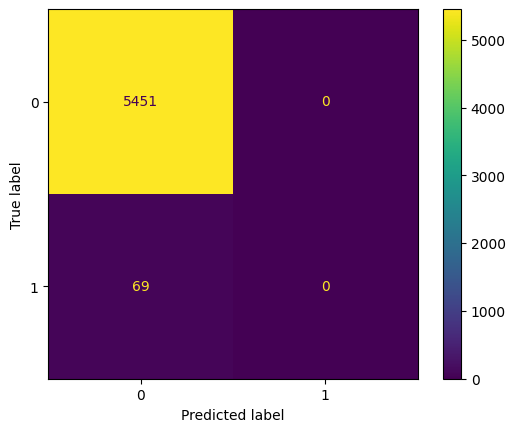

Fold: 3, defect_test_idx: {372}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


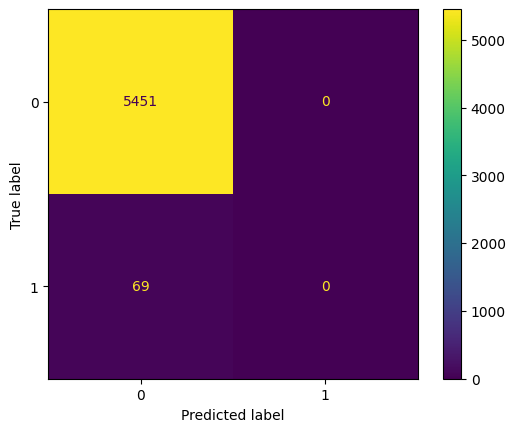

Fold: 4, defect_test_idx: {640}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


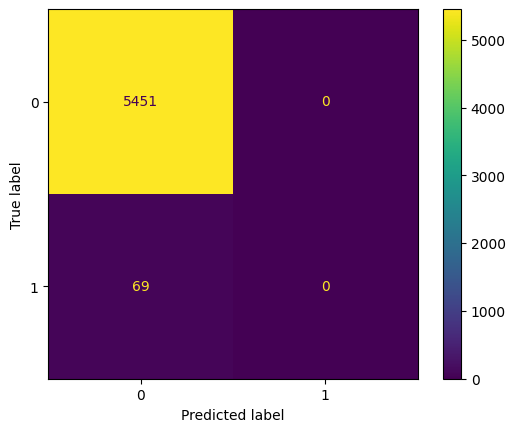

Fold: 5, defect_test_idx: {675}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


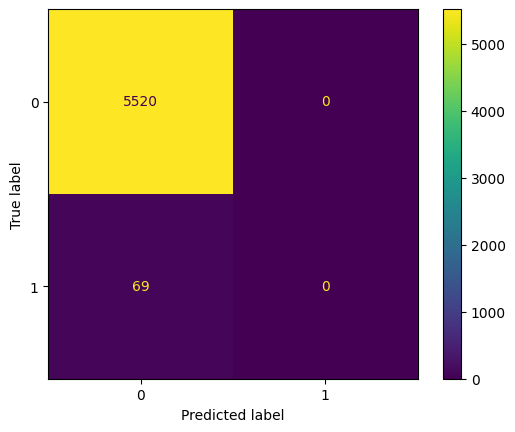

Fold: 6, defect_test_idx: {401}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


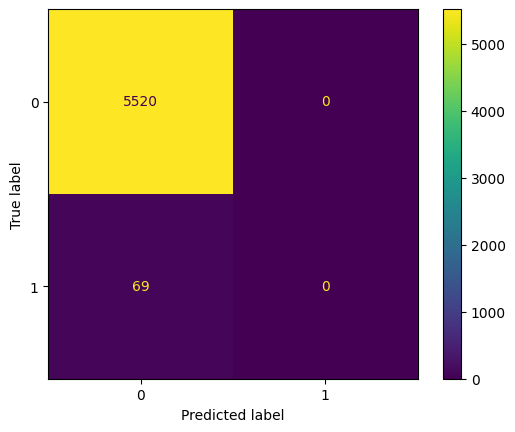

Fold: 7, defect_test_idx: {179}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


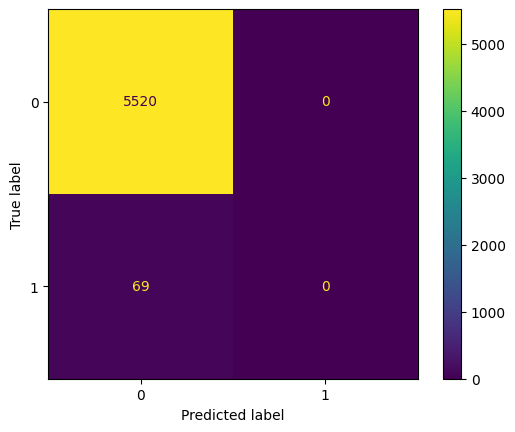

Fold: 8, defect_test_idx: {70}


e:\glass_git\ML-DL\.conda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


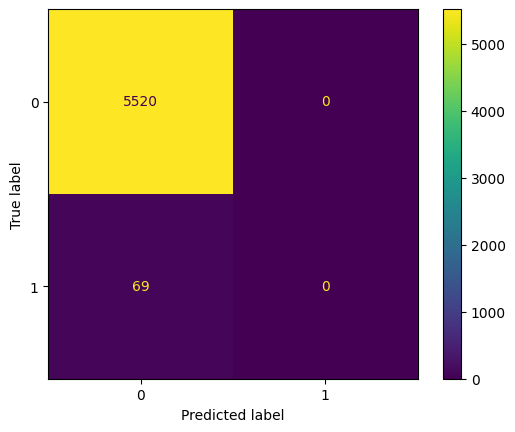

In [194]:
#year는 2021로 동일함으로 변수에서 제외, 스무딩 후 데이터
X_col=['pH_smooth','Temp_smooth','Voltage_smooth','month','day','hour','minutes','seconds','timestamp']
y_col=['class']

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_score=[]

X = df[X_col]
y = df[y_col]
groups = df['Index']

sgkf=StratifiedGroupKFold(n_splits=9, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    test_df=df[df['Index'].isin(groups[test_index].unique())]
    train_df=df[df['Index'].isin(groups[train_index].unique())]
    print(f'Fold: {i}, defect_test_idx: {set(defect_index_list)&set(groups[test_index].unique())}')

    train_x=train_df[X_col]
    train_y=train_df[y_col]

    test_x=test_df[X_col]
    test_y=test_df[y_col]

    #TRAIN
    clf.fit(train_x, train_y)
    y_pred=clf.predict(test_x)
    svc_score.append(clf.score(test_x,test_y))
    ConfusionMatrixDisplay.from_predictions(test_y, y_pred)
    plt.show()
    plt.close()

- SVC 모델과  XGBoost 모델 모두 defect 전혀 맞추지 못함
- data에 smoothing 전처리 유무는 단순 classification 모델에서는 성능 향상에 도움이 되지 않음

### Anomaly detection

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
import ast

def train_score(feat, normal_df, defect_df):
       train_x=normal_df[feat]
       scaler=StandardScaler()
       scaled_train_x=scaler.fit_transform(train_x)

       test_x=defect_df[feat]
       scaled_test_x=scaler.transform(test_x)
       test_y=defect_df['class']
       test_y.replace(1,-1,inplace=True) # 불량 : -1, outlier
       test_y.replace(0,1,inplace=True)  # 양품 : 1, inliner

       clf = IsolationForest(n_estimators=1000,bootstrap=True,random_state=42).fit(scaled_train_x)
       y_pred=clf.predict(scaled_test_x)
       acc=accuracy_score(test_y.to_list(), y_pred.tolist())
       return acc

def feature_selection1(normal_df,defect_df):
       X_fix=['pH', 'Temp', 'Voltage', 'run_time', 'month', 'day',  'hour', 'minutes','seconds',  'fft_pH_real',
              'fft_pH_imag', 'fft_pH_magnitude', 'fft_pH_phase', 'fft_Temp_real','fft_Temp_imag', 'fft_Temp_magnitude', 
              'fft_Temp_phase','fft_Voltage_real', 'fft_Voltage_imag', 'fft_Voltage_magnitude','fft_Voltage_phase']
       y_col=['class']

       select =[]
       score={}
       feat=X_fix
       i=len(feat)-1

       while i>0:
              
              train_x=normal_df[feat]
              scaler=StandardScaler()
              scaled_train_x=scaler.fit_transform(train_x)

              test_x=defect_df[feat]
              scaled_test_x=scaler.transform(test_x)
              test_y=defect_df[y_col]
              test_y.replace(1,-1,inplace=True) # 불량 : -1, outlier
              test_y.replace(0,1,inplace=True)  # 양품 : 1, inliner

              clf = IsolationForest(n_estimators=1000,bootstrap=True,random_state=42).fit(scaled_train_x)
              y_pred1=clf.predict(scaled_test_x)
              acc=accuracy_score(test_y['class'].to_list(), y_pred1.tolist())
              if len(score)!=0:
                     if best<=acc:
                            best=acc
                            score[str(feat)]=acc
                            selected_feat=X_fix[i]
                            select.append(selected_feat)
                            feat.remove(selected_feat)
                            i-=1
                            
                     else:
                            if selected_feat:
                                   feat.append(selected_feat)
                            
                                   selected_feat=X_fix[i]
                                   select.append(selected_feat)
                                   feat.remove(selected_feat)
                                   i-=1
                            else:
                                   selected_feat=X_fix[i]
                                   select.append(selected_feat)
                                   feat.remove(selected_feat)
                                   i-=1
              
              else:
                     best=acc
                     score[str(feat)]=acc
                     selected_feat=X_fix[i]
                     feat.remove(selected_feat)
                     i-=1
              
              # print(i,selected_feat)
              
       sorted_select_score1 = dict(sorted(score.items(), key=lambda item: item[1], reverse=True))
       best_feat1=list(sorted_select_score1.keys())[0]
       best_score1=sorted_select_score1[best_feat1]
       best_feat1=ast.literal_eval(best_feat1)
       # print(best_feat1,':',best_score1)
       return best_feat1,best_score1

def feature_selection2(best_feat1,best_score1,normal_df,defect_df):
       X_fix=best_feat1
       score={}
       best_SCORE=best_score1
       update=True
       score[str(X_fix)]=best_SCORE

       while update:
              select_score={}
              # print(X_fix)
              for i,selected_feat in enumerate(X_fix):
                     # print(i,':',selected_feat)
                     feat=X_fix.copy()
                     feat.remove(selected_feat)
                     acc=train_score(feat, normal_df, defect_df)
                     select_score[str(feat)]=acc
              sorted_select_score = dict(sorted(select_score.items(), key=lambda item: item[1], reverse=True))
              best_feat=list(sorted_select_score.keys())[0]
              best_score=sorted_select_score[best_feat]
              # print(best_feat,':',best_score)
              X_fix=ast.literal_eval(best_feat)
              if (best_SCORE<=best_score)&(len(X_fix)>1):
                     best_SCORE=best_score
                     score[str(best_feat)]=best_score
                     update=True
              else:
                     update=False
       final_score = dict(sorted(score.items(), key=lambda item: item[1], reverse=True))
       final_feat=list(final_score.keys())[0]
       final_score=final_score[final_feat]
       print(final_feat,':',final_score)
       return ast.literal_eval(final_feat), final_score

def cross_validation(final_feat,df):
       normal_index_list=df[df['class']==0]['Index'].unique()
       defect_index_list=df[df['class']==1]['Index'].unique()
       SCORES=[]
       for i in range(10):
              normal_n=np.random.choice(normal_index_list,size=9,replace=False)

              test_index=np.append(defect_index_list,normal_n)
              train_index=np.setdiff1d(normal_index_list,normal_n)

              defect_df=df[df['Index'].isin(test_index)]
              normal_df=df[df['Index'].isin(train_index)]
              acc=train_score(final_feat, normal_df, defect_df)
              SCORES.append(acc)
       print(np.mean(SCORES))
       return SCORES,np.mean(SCORES)

for a in range(10):
       normal_index_list=df[df['class']==0]['Index'].unique()
       defect_index_list=df[df['class']==1]['Index'].unique()
       #feature 찾기
       normal_n=np.random.choice(normal_index_list,size=9,replace=False)

       test_index=np.append(defect_index_list,normal_n)
       train_index=np.setdiff1d(normal_index_list,normal_n)

       defect_df=df[df['Index'].isin(test_index)]
       normal_df=df[df['Index'].isin(train_index)]


       best_feat1,best_score1=feature_selection1(normal_df,defect_df)
       if best_score1>=0.6:
              final_feat,final_score=feature_selection2(best_feat1,best_score1,normal_df,defect_df)
       else:
              continue
       #feature 검증
       
       SCORES,mean_Score=cross_validation(final_feat,df)
       print(f'{a}: {mean_Score}')

['minutes', 'hour', 'day', 'month'] : 1.0
0.5357149374892194
1: 0.5357149374892194
['month', 'minutes', 'hour'] : 0.9441666666666667
0.5725832680808102
2: 0.5725832680808102
['month', 'day', 'hour', 'minutes', 'seconds', 'fft_Voltage_phase'] : 0.917910447761194
0.5738558735031585
3: 0.5738558735031585
['month', 'hour', 'minutes', 'seconds', 'fft_Temp_phase'] : 0.9402489626556016
0.5426286978157768
4: 0.5426286978157768
['pH', 'Temp', 'fft_Voltage_magnitude', 'fft_Voltage_imag', 'fft_Voltage_real', 'fft_Temp_phase', 'fft_pH_phase', 'minutes', 'hour', 'month'] : 0.6639004149377593
0.6094122118923427
6: 0.6094122118923427
['Temp', 'fft_Voltage_phase', 'fft_Temp_phase', 'seconds', 'minutes', 'hour', 'month', 'run_time'] : 0.8662207357859532
0.5701544531582484
8: 0.5701544531582484


In [125]:
X_col2=['pH','Temp','Voltage','month','day','hour','minutes','seconds','run_time']
y_col=['class']

normal_index_list=df[df['class']==0]['Index'].unique()
defect_index_list=df[df['class']==1]['Index'].unique()
SCORES=[]
for i in range(10):
    normal_n=np.random.choice(normal_index_list,size=9,replace=False)

    test_index=np.append(defect_index_list,normal_n)
    train_index=np.setdiff1d(normal_index_list,normal_n)

    defect_df=df[df['Index'].isin(test_index)]
    normal_df=df[df['Index'].isin(train_index)]
    
    train_x=normal_df[X_col2]
    scaler=StandardScaler()
    scaled_train_x=scaler.fit_transform(train_x)

    test_x=defect_df[X_col2]
    scaled_test_x=scaler.transform(test_x)
    test_y=defect_df[y_col]
    test_y.replace(1,-1,inplace=True) # 불량 : -1, outlier
    test_y.replace(0,1,inplace=True)  # 양품 : 1, inliner

    clf = IsolationForest(random_state=42).fit(scaled_train_x)
    y_pred=clf.predict(scaled_test_x)
    acc=accuracy_score(test_y, y_pred.tolist())
    SCORES.append(acc)
    # ConfusionMatrixDisplay.from_predictions(test_y, y_pred)
    # plt.title('Smoothing feature')
    # plt.show()
    # plt.close()
np.mean(SCORES)

0.5952318556051537

In [58]:
#모델 결과 스무딩 전 모델이 성능이 더 우수, data는 smoothing 하지 않는 것으로 
from sklearn.metrics import accuracy_score

no_smooth_acc=accuracy_score(test_y['class'].to_list(), y_pred1.tolist())
smooth_acc=accuracy_score(test_y['class'].to_list(), y_pred2.tolist())
print(f'스무딩 전 모델 정확도: {no_smooth_acc}, 스무딩 후 모델 정확도: {smooth_acc}')

스무딩 전 모델 정확도: 0.6143317230273752, 스무딩 후 모델 정확도: 0.5966183574879227


In [174]:
#feature engineering를 하지 않는게 더 성능이 더 좋음
no_smooth_acc=accuracy_score(test_y['class'].to_list(), y_pred1.tolist())
smooth_acc=accuracy_score(test_y['class'].to_list(), y_pred2.tolist())
print(f'기본 feature: {no_smooth_acc}, diff feature 추가: {smooth_acc}')

기본 feature: 0.6159420289855072, diff feature 추가: 0.6360708534621579


## 결론

1. abnormal이 normal의 5%도 안되는 극심한 class imbalnce 존재 --> abnormaly detection 모델인 Isolation Foreset 적용
2. feature engineering 결과
    - pH, Temp, Voltage는 smoothing 하지 않는게 좋음 --> 정확도 감소
    - pH, Temp, Voltage에서 이전 값과의 차이는 사용하지 않는게 좋음  --> 정확도 감소


### 새로알게 된 사실
1. class 비율, data 크기에 따라 feature의 영향도도 변경됨
    - normal: 1, abnoraml: 9 인 경우에는 기본 feature만 사용한 모델이 3%가량 정확도가 더 높음
    - normal: 9, abnormal: 9 인 경우에는 feature를 추가한 경우가 기본 모델보다 2% 만큼 정확도가 높음
    - 1:9 비율일 떄는 정확도가 80%이상이었지만 1:1 비율일 때는 60%로 줄어듬 --> test 데이터가 많아질 수록 정확도가 떨어짐, 모델이 안정적이지 못함, 과소적합